In [28]:
import subprocess
import matplotlib.pyplot as plt
import pandas as pd
from multiprocess import Process

# Constants

In [29]:
RESULTS_DIR = 'results'
FLOW_DIR = 'flow'
CWND_DIR = 'cwnd'
CONGESTION_MECHANISMS_PREFIX = 'ns3::Tcp'

CONGESTION_MECHANISMS = [
    'LinuxReno',
    'Vegas',
    'Ledbat',
    'Dctcp',
    'Bbr',
    'Cubic',
    
    # 'Bic',
    # 'HighSpeed',
    # 'Htcp',
    # 'Hybla',
    # 'Illinois',
    # 'Lp',
    # 'Scalable',
    # 'Veno',
    # 'WestwoodPlus',
    # 'Yeah'
]

# Generate Flow Stats

In [30]:
subprocess.call('.././ns3 build'.split()) 

def run_simulation(mechanism: str):
    sim_cmd = ['.././ns3 run project.cc --']
    sim_cmd.append(f'--transportProtocol={CONGESTION_MECHANISMS_PREFIX}{mechanism}')
    sim_cmd.append(f'--flowStatFile={RESULTS_DIR}/{FLOW_DIR}/{mechanism}_flow_stats.csv')

    sim_cmd = ' '.join(sim_cmd)
    print(sim_cmd.strip())

    subprocess.call(sim_cmd.strip().split())

process_list: list[Process] = []
for mechanism in CONGESTION_MECHANISMS:
    process = Process(target=run_simulation, args=(mechanism, ))
    process.start()
    process_list.append(process)

for process in process_list:
    process.join()

Finished executing the following commands:
cd cmake-cache; /usr/local/bin/cmake --build . -j 7 ; cd ..
.././ns3 run project.cc -- --transportProtocol=ns3::TcpLinuxReno --flowStatFile=results/flow/LinuxReno_flow_stats.csv
.././ns3 run project.cc -- --transportProtocol=ns3::TcpVegas --flowStatFile=results/flow/Vegas_flow_stats.csv
.././ns3 run project.cc -- --transportProtocol=ns3::TcpLedbat --flowStatFile=results/flow/Ledbat_flow_stats.csv
.././ns3 run project.cc -- --transportProtocol=ns3::TcpDctcp --flowStatFile=results/flow/Dctcp_flow_stats.csv
.././ns3 run project.cc -- --transportProtocol=ns3::TcpBbr --flowStatFile=results/flow/Bbr_flow_stats.csv
.././ns3 run project.cc -- --transportProtocol=ns3::TcpCubic --flowStatFile=results/flow/Cubic_flow_stats.csv


In [31]:
data_collection = []

flow_data = pd.DataFrame()
for mechanism in CONGESTION_MECHANISMS:
    flow_file = f'../{RESULTS_DIR}/{FLOW_DIR}/{mechanism}_flow_stats.csv'

    data = pd.read_csv(flow_file)
    data.insert(0, 'Algorithm', mechanism)
    
    data_collection.append(data)

data = pd.concat(data_collection, ignore_index=True)

data

,Algorithm,Flow ID,Time,Throughput,Packets Dropped,Fairness,Window Size
0,LinuxReno,0,0.501,0.001725,0,0.388455,1
1,LinuxReno,1,0.501,0.001725,0,0.388455,1
2,LinuxReno,2,0.501,0.011114,0,0.388455,1
3,LinuxReno,3,0.501,0.001725,0,0.388455,1
4,LinuxReno,0,0.506,0.001708,0,0.437888,1
...,...,...,...,...,...,...,...
2877595,Cubic,3,599.991,0.003318,487,0.646897,58
2877596,Cubic,0,599.996,0.005363,534,0.646897,58
2877597,Cubic,1,599.996,0.000354,0,0.646897,58
2877598,Cubic,2,599.996,0.002001,357,0.646897,58


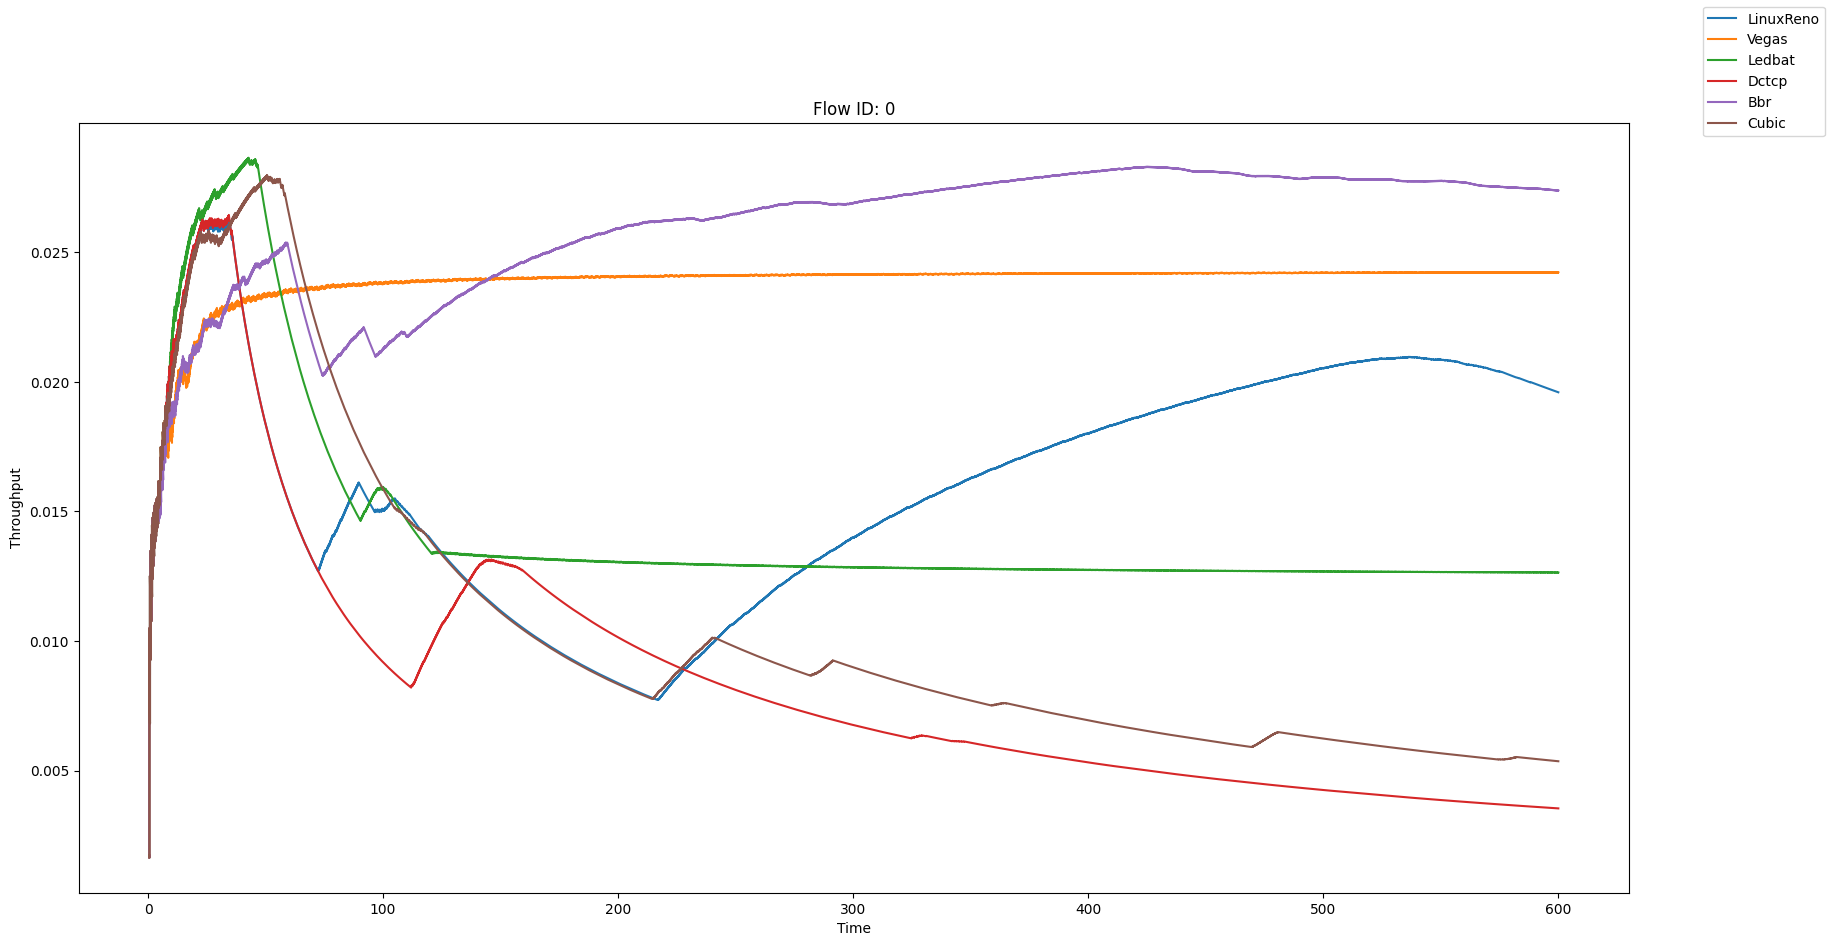

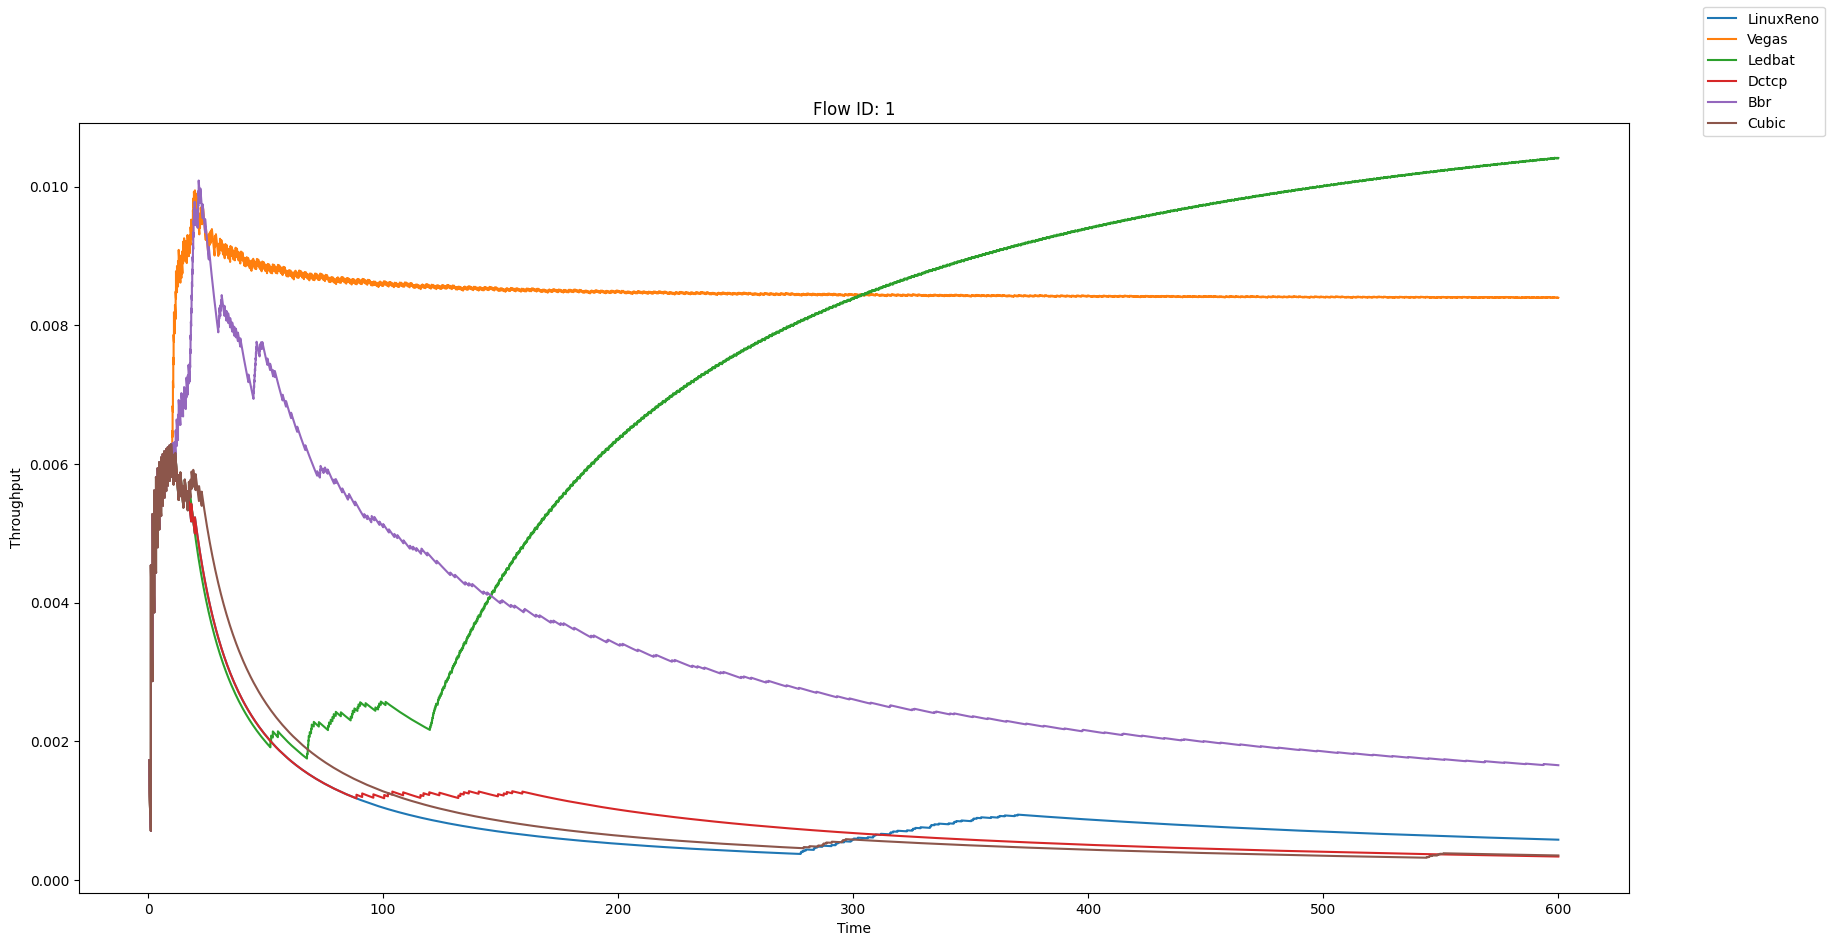

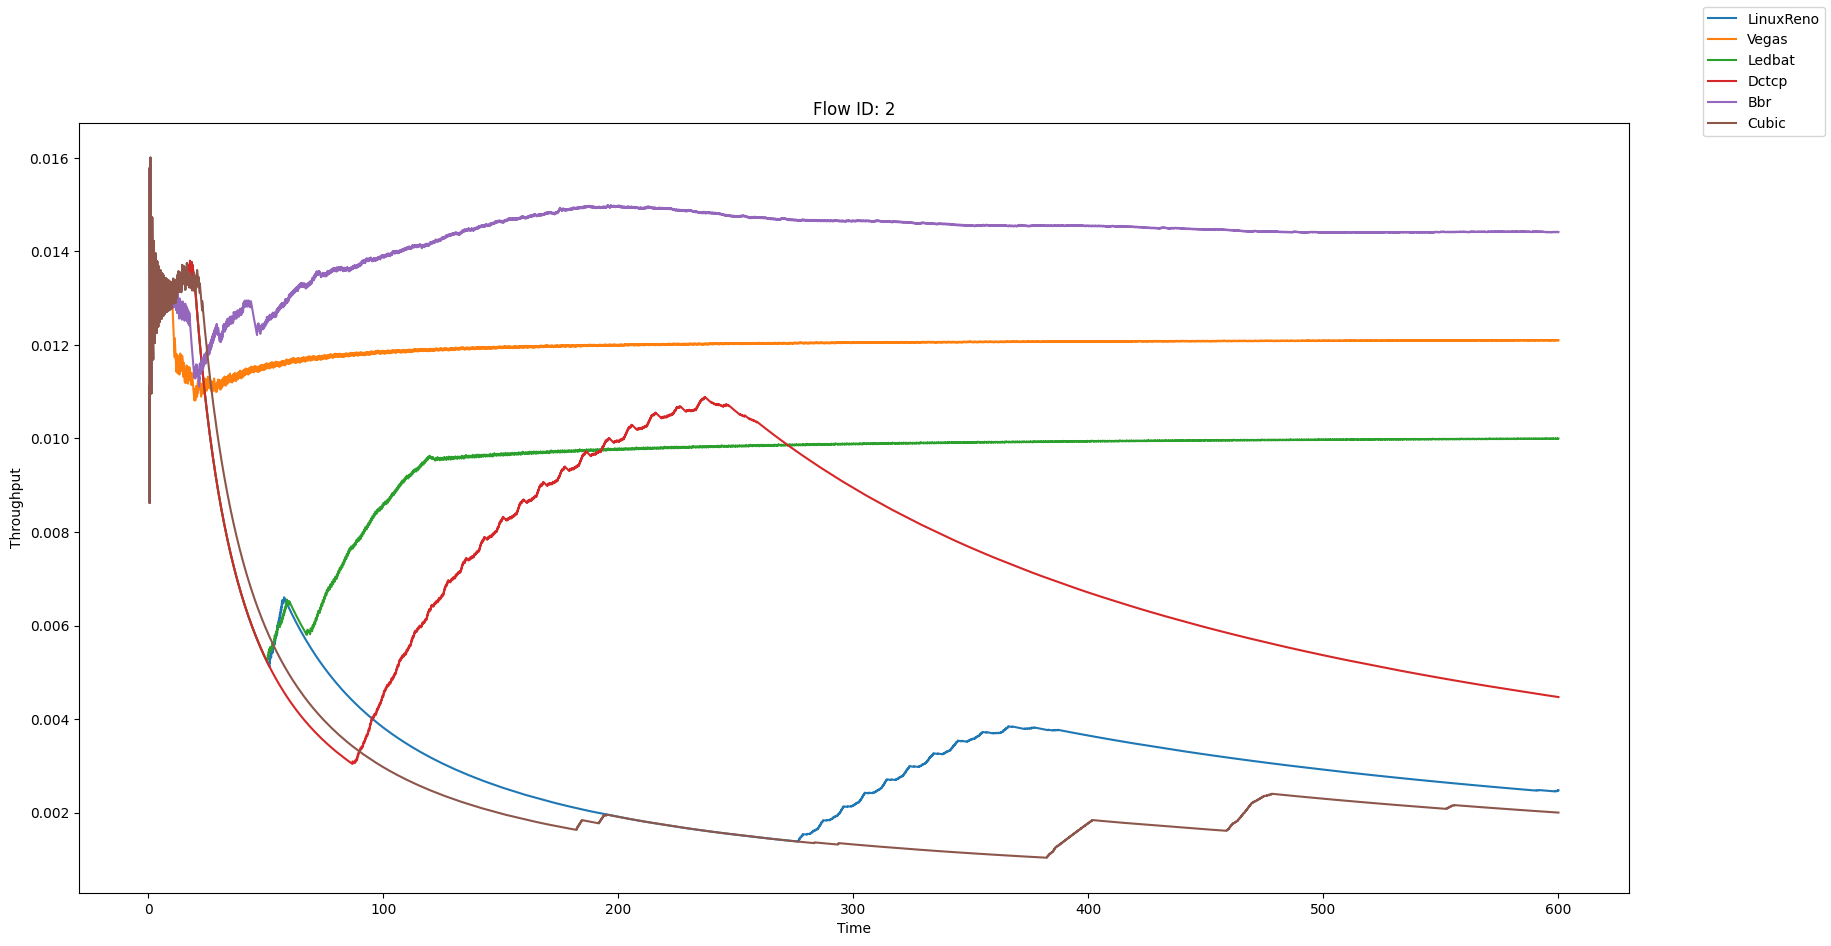

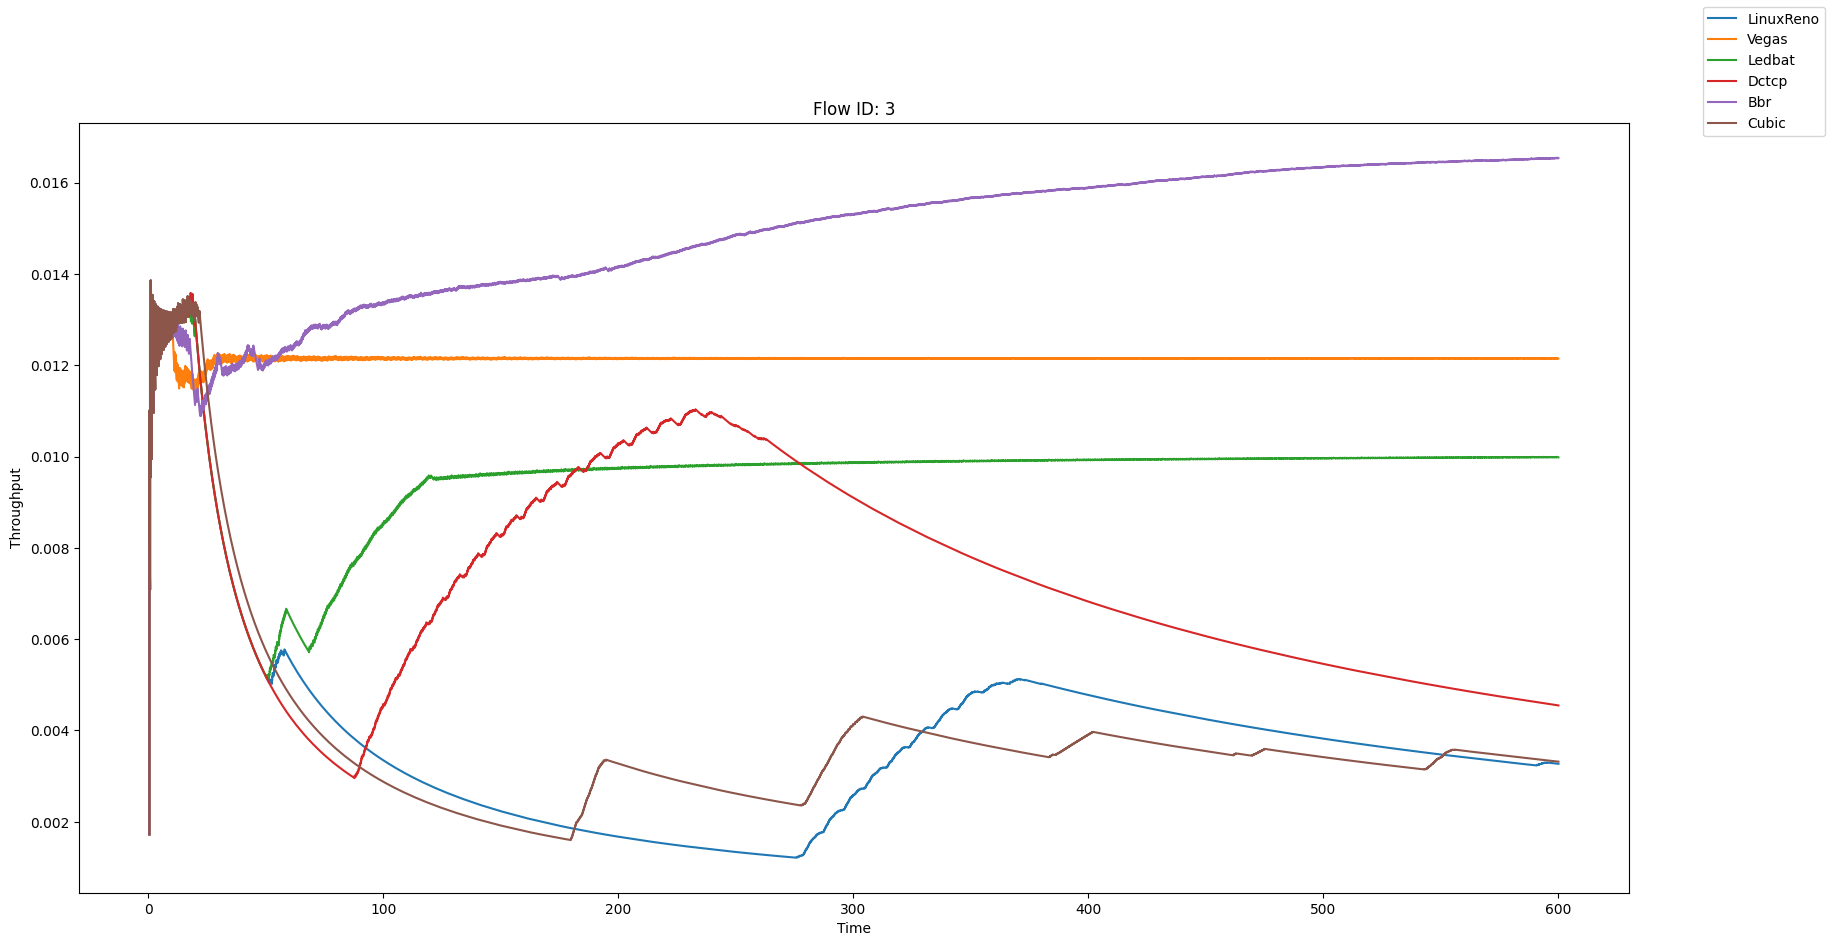

In [33]:
metric = 'Throughput'
flow_id = data['Flow ID'].unique()

ax = []
fig = []
for _ in flow_id:
    _fig, _ax = plt.subplots(figsize=(20, 10))
    ax.append(_ax)
    fig.append(_fig)

plot_index = 0
for mechanism in CONGESTION_MECHANISMS:
    for flow in flow_id:
        # Filter the data for the current data ID
        mechanism_data = data[(data['Algorithm'] == mechanism) & (data['Flow ID'] == flow)]
        # Create the plot
        ax[plot_index].plot(mechanism_data['Time'], mechanism_data[metric], label=mechanism)
        
        # Add labels and legend to the plot
        ax[plot_index].title.set_text(f'Flow ID: {flow}')
        ax[plot_index].set_xlabel('Time')
        ax[plot_index].set_ylabel(metric)
        # ax.set_yscale('log')
        # ax.set_xscale('log')
        plot_index += 1

    plot_index = 0
    
for f in fig:
    f.legend()

# Show the plot
plt.show()
plt.close()